In [1]:
# this file calculates raster statistics of a specified polygon. 

# 1. import target raster (.tif) and polygon i.e. (.shp) files
# 2. merge polygons based on chosen attribute 'group_by', this allows for weighted mean sampling
# 3. extract raster band statisitcs (e.g. mean, std, pixel count)
# 4. create new dataframe of just band values for plotting, color by 'group_by' attribute
# 5. create new dataframe of just band value standard error
# 6. create new dataframe of just variables asscoated with band values e.g. age, unit, fan, etc.
# 7. export data
# 8.(optional) normalize data (choose method), re-plopt

# ** attributes and values to be organized in GIS software prior to import
# ** pay attention to which attributed are being carried though from the .shp

In [1]:
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
import rasterstats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from os import path
from shapely.geometry import box
import openpyxl

# identify working directories for exports
current_dir = os.getcwd() # current directory for scripts/git
parent_dir = os.path.dirname(current_dir) # one level up for exports
parent_dir = os.path.dirname(parent_dir)

In [29]:
### group imported polygons by chosen attriute ###
#locate files (*manual*)
#target_data_file = r'C:\Users\htccr\Documents\Aconquija\imagery\landsat8\export\clipped\Landsat8_SR_stacked_clipped-surfaces_BCET.tif'
#target_data_file = r'C:\Users\htccr\Documents\Aconquija\imagery\landsat8\export\clipped\Landsat8_SR_stacked_clipped-surfaces_BCET.tif'
#target_data_file = r'C:\Users\htccr\Documents\Aconquija\imagery\WV3\010518244010_01\exports\clipped\WV3_SR_stack_downsample_clip-surfaces.tif'
target_data_file = r'C:\Users\htccr\Documents\Aconquija\imagery\prisma\PRS_L2D_STD_20210815143130_20210815143134_0001\exports\clipped\PRIMSA_20210815_stack_ortho_clip-surfaces.tif'
polygon_file = r'C:\Users\htccr\Documents\Aconquija\GIS_data\SPOTS_2_joined.shp'
#polygon_file = r'C:\Users\htccr\Documents\Aconquija\GIS_data\ages_surfaces.shp'
name_out = 'spots_dissolved.shp'
sensor = 'PRISMA_surfaces'

group_by = 'age' # (*manual*)

# create a dictionary
grouped = {}
# open your file with geopandas
polygons_raw = GeoDataFrame.from_file(polygon_file)
polygons = GeoDataFrame.from_file(polygon_file)

for i in range(len(polygons)):
    grouped_id = polygons.at[i, group_by]
    polygons_geometry = polygons.at[i, 'geometry']
    
    # if the feature's grouped doesn't yet exist, create it and assign a list
    if grouped_id not in grouped:
        grouped[grouped_id] = []
    # append the feature to the list of features
    grouped[grouped_id].append(polygons_geometry)

# create a geopandas geodataframe, with columns for grouped and geometry
grouped_dissolved = GeoDataFrame(columns=['grouped', 'geometry'], crs=polygons.crs)

# iterate your dictionary
for grouped, polygons_list in grouped.items():
    # create a geoseries from the list of features
    geometry = GeoSeries(polygons_list)
    # use unary_union to join them, thus returning polygon or multi-polygon
    geometry = geometry.unary_union
    # set your grouped and geometry values
    grouped_dissolved.at[grouped, 'grouped'] = grouped #round(grouped,2)
    grouped_dissolved.at[grouped, 'geometry'] = geometry

grouped_dissolved = grouped_dissolved.sort_values(by=['grouped'])
grouped_dissolved.head()

# save to file
#grouped_dissolved.to_file(name_out, driver="ESRI Shapefile")

,grouped,geometry
0.00000,0.0,"MULTIPOLYGON (((771671.060 6985754.764, 771676..."
3.37000,3.37,"MULTIPOLYGON (((781762.307 6991938.115, 781766..."
5.10667,5.10667,"MULTIPOLYGON (((776809.958 6989773.170, 776817..."
5.30000,5.3,"MULTIPOLYGON (((773204.872 6984804.123, 773209..."
5.40000,5.4,"MULTIPOLYGON (((780716.558 6993548.194, 780724..."


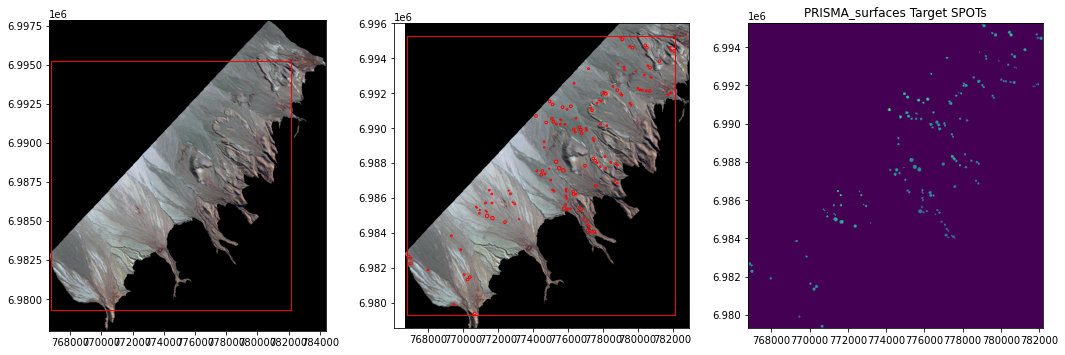

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 591,
 'height': 663,
 'count': 234,
 'crs': CRS.from_epsg(32719),
 'transform': Affine(29.99981, 0.0, 766641.15,
        0.0, -30.0, 6997860.133)}

In [30]:
### PLOT files to check polygon locations ### (*manual*)
#locate files

## READ IN FILES
# Multiband Raster
data_src = rio.open(target_data_file, 'r')
data_profile = data_src.profile
count = data_profile['count'] # How many bands are in our image?

# RGB raster (for plotting)
rgb_file = parent_dir + '\outputs\\aconquija_Landsat642.tif' # use 'RGB_composite.ipynb' to create RGB
rgb_src = rio.open(rgb_file, 'r')

# Polygons i.e Spots
#polygons = gpd.read_file(polygon_file)
polygons = grouped_dissolved

# create Geodataframe feature of polygons full extent (for plotting)
bbox_polygons = box(*polygons.total_bounds)
bbox_polygons = gpd.GeoDataFrame({"id":1,"geometry":[bbox_polygons]}) # create Geodataframne of the total extent of the polygon shapefile (for plotting)
extent_polygons = np.array(polygons.total_bounds) # extract numerical values for the polygons total extent (for plotting)

# mask and keep only pixels within polygons
masked, mask_transform = mask(dataset=data_src, shapes=polygons.geometry, crop=True, all_touched  = False, nodata = data_profile['nodata']) # mask pixs not within polygons i.e. Spots

## MOE MINUM N function
# function to determine minimum number (n) pixels to reach a designated Margin of Error given a specific confident interval (z score)
def margin_of_error(z, std, MOE):
    n_required = ((z*std)/MOE)**2
    return(n_required)

z = 1.96 # i.e 95% confidence interval (*manual*)
MOE = 250 # reflectance (*manual*)


## PLOT AND CHECK
saveIt = 0

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

show(rgb_src, ax = ax1)
bbox_polygons.plot(ax = ax1, facecolor = 'none', edgecolor = 'red')

show(rgb_src, ax = ax2)
bbox_polygons.plot(ax = ax2, facecolor = 'none', edgecolor = 'red')
polygons.plot(ax = ax2, facecolor = 'none', edgecolor = 'red')
ax2.set_xlim(extent_polygons[0] - 750, extent_polygons[2]+ 750)
ax2.set_ylim(extent_polygons[1] - 750, extent_polygons[3]+ 750)

show(masked[0], transform = mask_transform, ax = ax3) # optionally trasnform into geospatial coordinates, from mask meta. Plotting band 1 pix

plt.title('{} Target SPOTs'.format(sensor))
plt.tight_layout()
plt.show()

if saveIt:
    plt.savefig(parent_dir + '\outputs\\pix_converge_Q7_random.tif') # (*manual*)
    
plt.show()

# image metadata
data_src.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 591,
 'height': 663,
 'count': 234,
 'crs': CRS.from_epsg(32719),
 'transform': Affine(29.99981, 0.0, 766641.15,
        0.0, -30.0, 6997860.133)}

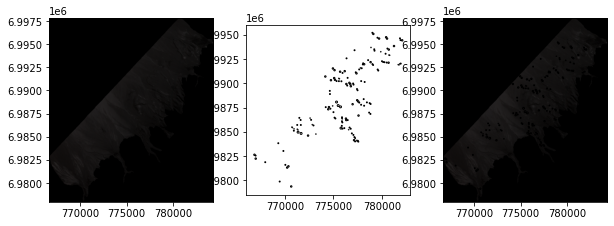

In [31]:
### plot & check metadata ###

#locate files
polygons = grouped_dissolved

# read in files
image = rio.open(target_data_file, mode = 'r')
#olygons = gpd.read_file(polygons_file)

# plot as check
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5))
show(image, ax = ax1)

polygons.plot(ax = ax2, facecolor = 'none', edgecolor = 'black')

show(image, ax = ax3)
polygons.plot(ax = ax3, facecolor = 'none', edgecolor = 'black')

# image metadata
image.meta

In [32]:
## Calculate raster statistics of each polygon i.e. fan, for each band 
# see for zonal_stats function info: https://pythonhosted.org/rasterstats/manual.html#zonal-statistics

meta = data_src.meta # variable for accessing meta data
affine = data_src.transform # record affine for stats below

# choose statistics to calculate
stats = ['mean', 'std', 'count'] # see default options from zonal_stats

# create empty array to fill with polygon attributes and new raster stats data from each fan, for each band
pix_stat_array = np.empty((meta['count'], len(polygons)), dtype = dict) # dtype only works as dict, list, or object (?)

# calculate zonal statistics    
for i in range(meta['count']): # for i in range of bands
    ii = i + 1
    image_array = image.read(ii) # read image at that band
    
    # calcuate new statistics and fill empty array with existing attributes and these.  
    pix_stat_array[i] = rasterstats.zonal_stats(polygons, image_array, affine = affine, # image array is grouped!
                                                stats = stats, # new stats 
                                                nodata = 0.0,
                                                geojson_out = True, # keep existing polygon attributes
                                                all_touched = False) # include edge pix? False means no

In [33]:
# check for new statistics!
pix_stat_array[0][0]['properties'] #array[band][unique fan]['properties i.e. attributes]

{'grouped': 0.0,
 'mean': 0.09501559688494755,
 'count': 208,
 'std': 0.010013546256354212}

In [34]:
# extract statistics from array, and create dataframe 
# 1. extract existing properties stored in the polygons e.g. age, unique id, etc.
# 2. create base dataframe, drop first set of new stats 
# 3. Loop through all unique fan surfaces i.e. polygons, by band and extract new statistics into lists
# 4. Append new stats list to the dataframe

properties_list = [] # create empty list to store 
for jj in range(len(polygons)): # for each fan...
    properties_list.append(pix_stat_array[0][jj]['properties']) # extract all properties i.e. existing attributes & new stats. 
    # ^ append to empty list

df = pd.DataFrame(properties_list) # create dataframe from list
df = df.drop(columns=stats) # drop the first 
df_std = pd.DataFrame(properties_list) # create dataframe from list
df_std = df_std.drop(columns=stats) # drop the first

# loop though statistics and append to new dataframe
for ii in range(meta['count']):
    mean_pix_list = []
    std_pix_list = []
    pix_count_list = []
    for jj in range(len(polygons)):
        mean_pix_list.append(pix_stat_array[ii][jj]['properties']['mean'])
        std_pix_list.append(pix_stat_array[ii][jj]['properties']['std'])
        pix_count_list.append(pix_stat_array[ii][jj]['properties']['count'])
    
    hold_bands = pd.Series(mean_pix_list, name = 'B{}_mean'.format(ii + 1))
    to_concat = [df, hold_bands]
    df = pd.concat(to_concat, axis = 1)
    
    hold_bands_std = pd.Series(std_pix_list, name = 'B{}_std'.format(ii + 1))
    to_concat = [df_std, hold_bands_std]
    df_std = pd.concat(to_concat, axis = 1)

df = df.copy()
df_std = df_std.copy()
df.head()

,grouped,B1_mean,B2_mean,B3_mean,B4_mean,B5_mean,B6_mean,B7_mean,B8_mean,B9_mean,...,B225_mean,B226_mean,B227_mean,B228_mean,B229_mean,B230_mean,B231_mean,B232_mean,B233_mean,B234_mean
0,0.00000,0.095016,0.087031,0.086043,0.092358,0.097595,0.104654,0.110789,0.113885,0.115541,...,0.201663,0.216025,0.164424,0.206316,0.219955,0.211810,0.201396,0.167160,0.383155,0.222965
1,3.37000,0.055733,0.052584,0.051416,0.058046,0.060646,0.066310,0.071811,0.075808,0.077169,...,0.161240,0.177098,0.144533,0.157196,0.184645,0.172011,0.166694,0.160067,0.387586,0.218806
2,5.10667,0.072552,0.066371,0.066350,0.070230,0.074420,0.080428,0.086002,0.088019,0.089246,...,0.160523,0.173540,0.132066,0.157797,0.173261,0.163852,0.155537,0.125692,0.179595,0.198340
3,5.30000,0.092628,0.084281,0.082825,0.088585,0.095247,0.103068,0.108866,0.111967,0.113537,...,0.205556,0.223030,0.167886,0.215340,0.225796,0.224041,0.212703,0.186396,0.524985,0.209790
4,5.40000,0.076524,0.071851,0.070685,0.075591,0.079310,0.085356,0.090487,0.093323,0.095023,...,0.185074,0.202293,0.156610,0.183150,0.206299,0.192420,0.186793,0.149483,0.450478,0.234317


In [35]:
# add variables to dataframe 
polygons_raw = pd.DataFrame(polygons_raw) # convert polygon geo-df to df
polygons_raw = polygons_raw.sort_values(by=[group_by]) # sort to be same as 'grouped'

# extract all variables from original dataset, using same grouping
unique = polygons_raw.groupby(group_by, as_index=False)['unique'].max()
unit = polygons_raw.groupby(group_by, as_index=False)['unit'].max()
fan = polygons_raw.groupby(group_by, as_index=False)['fan'].max()
age_n = polygons_raw.groupby(group_by, as_index=False)['age_n'].sum()
age_sd = polygons_raw.groupby(group_by, as_index=False)['age_sd'].mean()
age_sd = np.round(age_sd, 2)
#age = polygons_raw.groupby(group_by, as_index=False)['age'].mean()
age = df['grouped']
age = np.round(age, 2)


# loop through to add variables to df
data_vars = pd.DataFrame()
data_vars['age'] = age
data_vars['pix_count'] = pix_count_list
add = [age_sd, age_n, unique, unit, fan]
add_names = ['age_sd', 'age_n','unique','unit', 'fan']

for i,j in zip(add, add_names):
    data_vars['{}'.format(j)] = i.iloc[:,1]

# decompact data_vars
age = list(data_vars['age'])
age_sd = list(data_vars['age_sd'])
age_n = list(data_vars['age_n'])
fan = list(data_vars['fan'])
unit = list(data_vars['unit'])
unique = list(data_vars['unique'])
pix_count = list(data_vars['pix_count'])

In [36]:
# new df of just mean band values
bands_only = df.drop(columns=['grouped']) # drop specified columns
bands_std_only = df_std.drop(columns=['grouped']) # drop specified columns

#bands_only = bands_only.drop(columns = ['B{}_std'.format(i) for i in range(1, meta['count'] + 1)])

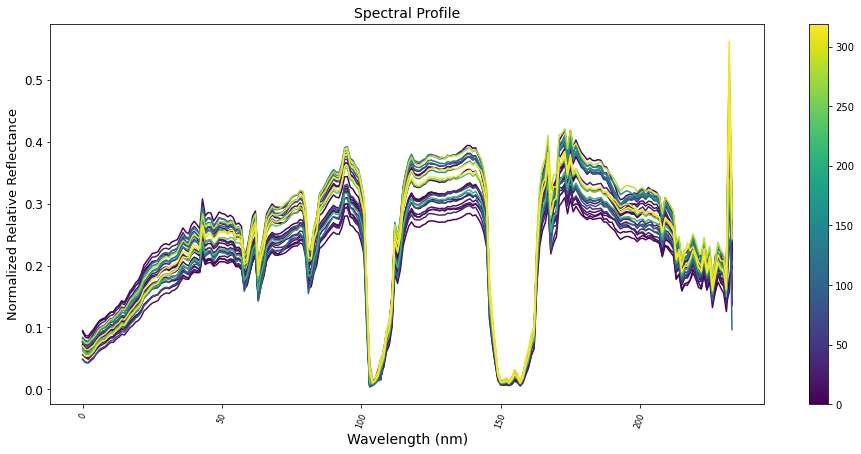

In [37]:
#plot
norm = plt.Normalize(vmin=min(age), vmax=max(age))

target_x = range(count)
target_y = bands_only
yerr = bands_std_only
target_names = age

N = len(target_y) # number of objects to plot i.e. color cycle count
fig, ax = plt.subplots(figsize = (16,7))
for i in range(N): 
    ax.plot(target_x, target_y.iloc[i],label = target_names[i], color=plt.cm.viridis(norm(age[i])))
   # ax.errorbar(target_x, target_y.iloc[i], yerr=yerr.iloc[i], color=plt.cm.viridis(norm(age[i])), alpha = 0.5, fmt='-o')
#axes
plt.xticks(fontsize = 10, rotation=70, size = 8)
plt.xlabel('Wavelength (nm)', fontsize = 14)
plt.yticks(fontsize = 12)
plt.ylabel('Normalized Relative Reflectance', fontsize = 13)
plt.title("Spectral Profile", size = 14)
plt.title
plt.xlim()
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis))

### normalization (paste one from options below)

In [39]:
# normalize to a particular band (i.e. to Band 1 as zero), scale all observation 0 - 1 
dat_norm = (bands_only.T -  bands_only.T.iloc[0]) # choose band as zero point
max_all = dat_norm.max().max()
min_all = dat_norm.min().min()
dat_norm = (dat_norm - min_all)/(max_all - min_all) 

# carry std through-- create relative matrix of std to refelctance value (i.e. decimel percentage), normlaize data, re-calc std using matrix
std_matrix  = bands_std_only.values/bands_only.values # create std matrix
dat_norm = dat_norm + 1 #add 1 to all, so no 0 values
dat_std_norm = std_matrix * dat_norm.T # apply std matrix

dat_norm = dat_norm - 1 # subract 1 back from reflectance values to rescale 0-1, not 1-2

### plot normalized data

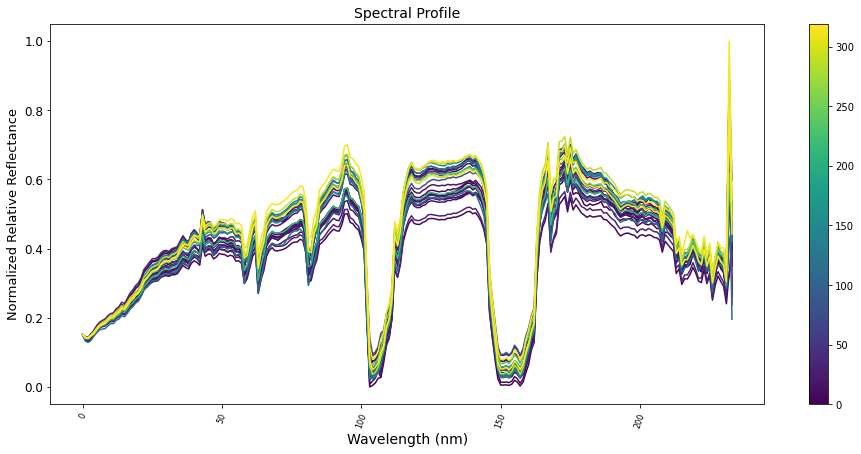

In [40]:
#plot
norm = plt.Normalize(vmin=min(age), vmax=max(age))

target_x = range(count)
target_y = dat_norm.T  # if shapes are different, add/remove .T
yerr = dat_std_norm
target_names = age

N = len(target_y) # number of objects to plot i.e. color cycle count
fig, ax = plt.subplots(figsize = (16,7))
for i in range(N): 
    ax.plot(target_x, target_y.iloc[i],label = target_names[i], color=plt.cm.viridis(norm(age[i])))
    #ax.errorbar(target_x, target_y.iloc[i], yerr=yerr.iloc[i], color=plt.cm.viridis(norm(age[i])), alpha = 0.5, fmt='-o')

#axes
plt.xticks(fontsize = 10, rotation=70, size = 8)
plt.xlabel('Wavelength (nm)', fontsize = 14)
plt.yticks(fontsize = 12)
plt.ylabel('Normalized Relative Reflectance', fontsize = 13)
plt.title("Spectral Profile", size = 14)
plt.title
plt.xlim()
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis))

(0.0, 350.0)

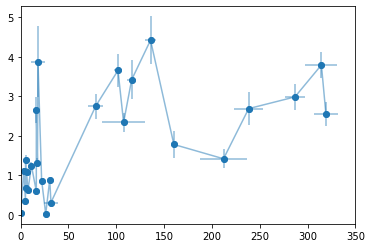

In [14]:
# test ratios versus age
# see for caluclating fractional uncertainities: https://idol.union.edu/vineyarm/teaching/phy17/uncertainties_intro.pdf

val1 = 5
val2 = 1

ratio = (dat_norm.T.iloc[:,val1]/dat_norm.T.iloc[:,val2])

ratio_std_matrix = std_matrix[:,val1] + std_matrix[:,val2] # calculate error matrix (i.e. sum of std for ratio values)
yerr = ratio*ratio_std_matrix # apply matrix to ratio values

plt.figure()
plt.scatter(age, ratio)
plt.errorbar(age, ratio, xerr=age_sd, yerr = yerr, alpha = 0.5, fmt='-o')
plt.xlim(0,350)

In [38]:
#log(0) # stop automatic kernal run, expots will overwrite.

### EXPORT DATA ### 
import openpyxl
from openpyxl.workbook import Workbook
outputs = r'C:/Users/htccr/Documents/Aconquija/python_scripts/outputs/' # output location

# prep datasets for export
export_bands = bands_only.copy()
export_bands = export_bands.T.reset_index(drop = True).T

export_std = bands_std_only.copy()
export_std = export_std.T.reset_index(drop = True).T

export_vars = data_vars

# save as single .xlsx with multiple sheets
with pd.ExcelWriter(outputs + sensor + '_spots.xlsx') as writer:  
    export_bands.to_excel(writer, sheet_name='band_mean', header = False, index = False)
    export_std.to_excel(writer, sheet_name='band_std', header = False, index = False)
    export_vars.to_excel(writer, sheet_name='variables', header = True, index = False)

### Normalization Options

In [16]:
# scale each observation to 0-1 range, independent of each other
dat_norm = (bands_only.T - bands_only.T.min())/(bands_only.T.max() - bands_only.T.min())

# carry std through-- create relative matrix of std to refelctance value (i.e. decimel percentage), normlaize data, re-calc std using matrix
std_matrix  = bands_std.values/bands_only.values # create std matrix
dat_norm = dat_norm + 1 #add 1 to all, so no 0 values
dat_std_norm = std_matrix * dat_norm.T # apply std matrix

dat_norm = dat_norm - 1 # subract 1 back from reflectance values to rescale 0-1, not 1-2

NameError: name 'bands_std' is not defined

In [ ]:
# scale all observation to 0-1 range, using the same min and max
max_all = bands_only.max().max()
min_all = bands_only.min().min()

#norm01 = (norm01 - norm01.min())/(norm01.max() - norm01.min())
dat_norm = (bands_only - min_all)/(max_all - min_all)

# carry std through-- create relative matrix of std to refelctance value (i.e. decimel percentage), normlaize data, re-calc std using matrix
std_matrix  = bands_std.values/bands_only.values # create std matrix
dat_norm = dat_norm + 1 #add 1 to all, so no 0 values
dat_std_norm = std_matrix * dat_norm # apply std matrix

dat_norm = dat_norm - 1 # subract 1 back from reflectance values to rescale 0-1, not 1-2

In [ ]:
# normalize to a particular band (i.e. to Band 1 as zero), scale all observation 0 - 1 
dat_norm = (bands_only.T -  bands_only.T.iloc[0]) # choose band as zero point
max_all = dat_norm.max().max()
min_all = dat_norm.min().min()
dat_norm = (dat_norm - min_all)/(max_all - min_all) 

# carry std through-- create relative matrix of std to refelctance value (i.e. decimel percentage), normlaize data, re-calc std using matrix
std_matrix  = bands_std.values/bands_only.values # create std matrix
dat_norm = dat_norm + 1 #add 1 to all, so no 0 values
dat_std_norm = std_matrix * dat_norm.T # apply std matrix

dat_norm = dat_norm - 1 # subract 1 back from reflectance values to rescale 0-1, not 1-2

In [ ]:
# normalize each observation to have the same mean & std
dat_norm = (bands_only.T - bands_only.T.mean())/bands_only.T.std()
#dat_norm = (bands_only - bands_only.mean())/bands_only.std() # normalize data for each individual bands i.e. each band has a mean spectral reflectance mean(B1) across observations
#dat_norm = (dat_norm.T - dat_norm.T.mean())/dat_norm.T.std() # normalized the normalized individual bands, across all bands i.e. across the spectrum

# carry std through-- create relative matrix of std to refelctance value (i.e. decimel percentage), normlaize data, re-calc std using matrix
std_matrix  = bands_std.values/bands_only.values # create std matrix
dat_norm = dat_norm + 1 #add 1 to all, so no 0 values
dat_std_norm = std_matrix * dat_norm.T # apply std matrix

dat_norm = dat_norm - 1 # subract 1 back from reflectance values to rescale 0-1, not 1-2

In [ ]:
# normlaize by BCET, on the final dataset (???)
# followed by normalization to a particular band

BCET = pd.DataFrame()

for band_n in range(count):

    # Read band
    dat = bands_only.iloc[:,band_n].astype(np.float64)

    # Shift the left minimum value to the current minimum, so the smallest value is now shifted to zero
    dat_masked_new = dat-np.min(dat)
    
    # Normalize between 0 and 1
    dat_masked_new *= 1/dat_masked_new.max()
    
    L = 0 # desired output minimum
    H = 1  # desired output maximum, set to max bit-depth range
    E = H/2 # desired output mean

    ### BCET ###

    s = np.nanmean(np.power(dat_masked_new,2)) # mean squared
    e = np.nanmean(dat_masked_new)
    l = np.nanmin(dat_masked_new)
    h = np.nanmax(dat_masked_new)

    # Find b
    b_nom = ((h**2)*(E-L))-(s*(H-L))+((l**2)*(H-E))
    b_den = 2*((h*(E-L))-(e*(H-L))+(l*(H-E)))

    b = b_nom/b_den

    # Find a
    a1 = H-L
    a2 = h-l
    a3 = h+l-(2*b)

    a = a1/(a2*a3)

    # Find c
    c = L-(a*(l-b)**2)
    
        # BCET malfunction test as in Lui & Mason (2016) Section 2.6.1. Where l<b<h BCET malfunctions. 
    if (l < b) & (b < h):
        print('\033[91m'+ 'BCET Fail' + '\033[0;0m' + ' (Band {})'.format(band_n + 1)) # print in red
    else:
        print('\033[92m' + 'BCET Pass' + '\033[0;0m' + ' (Band {})'.format(band_n + 1)) # print in green

    #print("l, b, h --> ", l,", ", b,", ",h)
    #print('------------------------------')
    #print(bcet_raster.shape)

    # Process raster
    bcet_raster = a*((dat_masked_new - b)**2) + c
    #BCET[band_n] = bcet_raster # replcaced w/ below
    hold = pd.Series(bcet_raster, name = band_n)
    to_concat = [BCET, hold]
    BCET = pd.concat(to_concat, axis = 1)

print('dynamic range ', L, 'to', H) # prints the desired dynamic range of the output image
print('target mean ', E) # prints the desired mean of the output image, 'E'
print('actual mean', np.mean(BCET.mean()))
print("processing complete.")
 
dat_norm = BCET

# BCET data-- normalize to a particular band (i.e. to Band 2 as zero)
dat_norm = (dat_norm.T -  dat_norm.T.iloc[0])
max_all = dat_norm.max().max()
min_all = dat_norm.min().min()

dat_norm = (dat_norm - min_all)/(max_all - min_all)

# carry std through-- create relative matrix of std to refelctance value (i.e. decimel percentage), normlaize data, re-calc std using matrix
std_matrix  = bands_std_only.values/bands_only.values # create std matrix
dat_norm = dat_norm + 1 #add 1 to all, so no 0 values
dat_std_norm = std_matrix * dat_norm.T # apply std matrix
dat_norm = dat_norm - 1 # subract 1 back from reflectance values to rescale 0-1, not 1-2